# Setup

Follow the steps below in order to run this notebook succesfully:
1. Ensure that the following files are in the folder as this rental_model file.
    - requirements.txt  ::  specifies which packages and versions to download
    - my_functions.py   ::  defines custome functions used in this notebook
2. If this is your first time running the notebook, execute the cell in the **Download Packages** section.
3. Run the cell below to import custom defined functions

In [1]:
# this is will import all the custom functions
from my_functions import *

# Sample Environment

## About the Macro Model
We specify a distribution and sample for CPI, PPI, and an interest rate (IR) series.

Here's how the distribution works:  

What we model is the drift from one quarter to the next.  These are specified as a multivariate normal distribution.  The variables are correlated, and all combinations follow one single correlation coefficient.  The mean of each variable changes at each period according to how far away it is from it's long-run value.  This tendency can be tuned with the 'avg_yrs_to_revert' parameter.  

A fraction of the time, we sample from a **tail distribution**. This is also a multivariate normal distribution with the same correlation as the **base distribution** (detailed above).  However, the variables in the tail distribution have a standard deviation that is a multiple above that of the base distribution (configurable).  The tail distribution does not have a tendency to revert to the long-run value, instead the mean is a fixed value (configurable).   

## Parameters
Provide the following parameters to define the Macro model:
- random_seed: keep the same seed for reproducibility
- start_val: value today (at t=0)
- floor: series is not allowed to fall below this value
- long_run: the long_run value it is expected to revert to
- std: standard deviation of the absolute change from one quarter to the next
- corr: correlation coefficient for all 3-choose-2 combinations. A value from 0 to 1.
- n_periods: number of quarters for which to generate figures
- avg_yrs_to_revert: average number of years after which figure should revert back to long-run expectation.  Controls strength of reversion.
- p_tail: probability with which the absolute YoY change is drawn from the **tail distribution**. In a tail event all three rates change with this distribution.
- tail_std_multiple: specifies what standard deviation to use in the **tail distribution** as a multiple of the standard deviation in the **base distribution**
- tail_event_mean: mean of the **tail distribution**.  Note: this is because the **tail distribution** has no reversion.
- n_samples: number of environments to sample

In [2]:
dist_params = {
    'random_seed': 999
    , 'cpi' : {
        'start_val': .05
        , 'floor': .01
        , 'long_run': .03
        , 'std': 0.005
    }
    , 'ppi' : {
        'start_val': .05
        , 'floor': .01
        , 'long_run': .03
        , 'std': 0.005
    }
    , 'ir' : {
        'start_val': .05
        , 'floor': .01
        , 'long_run': .03
        , 'std': 0.005
    }
    , 'corr': 0.8
    , 'n_periods': 40
    , 'avg_yrs_to_revert': 5
    , 'p_tail': 0.02
    , 'tail_std_multiple': 6
    , 'tail_event_mean': .01
    , 'n_samples': 150
}


In [3]:
# sample macro environments
sampled_environments = mass_sample_environments(dist_params)

Let's visualize all the different scenarios we just sampled. Blue dots identify where a tail event takes place. Play with the drop down to look at a different variable.

Tip: Use the alpha parameter to control the line darkness

In [4]:
f = lambda var: plot_all_scenarios(sampled_environments, var, alpha=.1, ylims=(0,0.15))
w = interactive(f, var = ['cpi', 'ppi', 'ir'])
w

interactive(children=(Dropdown(description='var', options=('cpi', 'ppi', 'ir'), value='cpi'), Output()), _dom_…

Though we plot for t=0 --> 40 (41 entries in total), the data point at t=0 is just to show that all series are starting at the same point. The only figures that get passed on to our calculations are those for t=1 --> 40 (40 entries total).

Let's visualize all three rates from one scenario at a time to see how they move together.  Move the slider to see another sampled environment.

In [5]:
f = lambda sample_id: plot_single_environment(sampled_environments, sample_id, ylims=(-0.1, 0.15))
w=interactive(f,sample_id=(0,sampled_environments['sample_id'].max(),1))
w

interactive(children=(IntSlider(value=74, description='sample_id', max=149), Output()), _dom_classes=('widget-…

# Analyze

Specify the scenario that you want to run the model under.  

Note: cpi, ppi, and index rate will be taken from the samples generated in the previous section.

Provide the following parameters:
- horizon_yrs : number of years to model
- periods_per_year: granularity at which to model (4 = quarterly, 12 = monthly)
- gross_income : annual rental income under full occupancy
- net_income : rental income after maintenance expenses under full occupancy
- vacancy_rate : percentage of rental income expected to miss out on due to vacancy
- is_inflation_indexed: whether or not rental price updates each Q1 to reflect prior year inflation. So rental income is 'catching up' to inflation at the beginning of each year.
- rrr_exit: expected ratio of net_income to asset_price for the overall market at time of exit
- deflated_cap_gain: % above or below market rates that the property is expected to trade at.  Specific to the property.
- financing.is_fixed_rate: whether or not the financing uses a fixed rate
- financing.is_amortizing: whether or not the financing requires making payments towards the principal
- financing.term: term of the loan in years
- financing.fixed_rate: fixed rate paid on the loan. Only applies if financing.is_fixed_rate == True
- financing.margin : margin over index rate that yields the applicable rate
- financing.ltv_ratio: share of purchase price that is financed at t=0

In [6]:
scenario = {
    'horizon_yrs': 10
    , 'periods_per_year': 4
    , 'gross_income': 2000
    , 'net_income': 1800
    , 'vacancy_rate': .05
    , 'is_inflation_indexed': True
    , 'rrr_exit': .069
    , 'deflated_cap_gain': .04
    , 'financing': {
        'is_fixed_rate': False
        , 'is_amortizing': False
        , 'term': 20
        , 'fixed_rate': .03
        , 'margin': 0
        , 'ltv_ratio': .50
    }
}

## Find Purchase Price that Yields Target IRR in Each Macro Scenario

The cell below will compute the corresponding purchase price given the scenario and target IRR, under each of the different rate environments sampled in the previous section. **Input below the target IRR.**

In [7]:
target_irr = 0.03 ## edit this value
scored_purchase = run_all_scenarios(sampled_environments, scenario, get_irr, target_irr)
## this cell may take ~20sec to run

### Plot Results

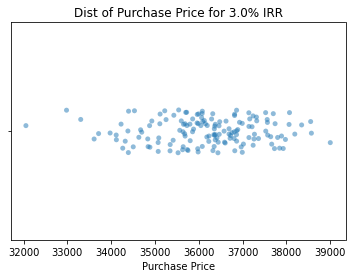

In [8]:
ax = sns.stripplot(data=scored_purchase, x = 'purchase_price', alpha = 0.5)
ax.set_xlabel('Purchase Price')
ax.set_title(f'Dist of Purchase Price for {100*target_irr:0.1f}% IRR')
plt.show()

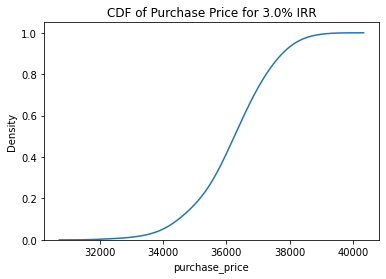

In [9]:
ax = sns.kdeplot(data = scored_purchase['purchase_price'], cumulative = True)
ax.set_title(f'CDF of Purchase Price for {100*target_irr:0.1f}% IRR')
plt.show()

## Find IRR Given a Fixed Purchase Price in Each Scenario

Now let's run it the other way.  Given a fixed purchase price, what does IRR look like across scenarios. **Input below the purchase price to use for all scenarios.**

In [10]:
purchase_price = 35000   ### edit this input
scored_irr = run_all_get_performance(sampled_environments, scenario, purchase_price, get_irr, 'irr')

### Plot Results

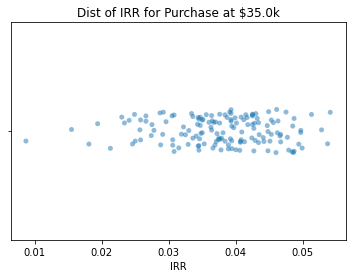

In [11]:
ax = sns.stripplot(data=scored_irr, x = 'irr', alpha = 0.5)
ax.set_xlabel('IRR')
ax.set_title(f'Dist of IRR for Purchase at ${purchase_price/1e3:0.1f}k')
plt.show()

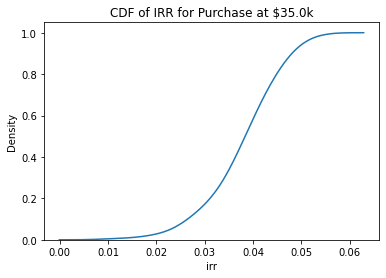

In [12]:
ax = sns.kdeplot(data = scored_irr['irr'], cumulative = True)
ax.set_title(f'CDF of IRR for Purchase at ${purchase_price/1e3:0.1f}k')
plt.show()

# Export Data

The below code saves the sampled environments and scoring results to csv files.  A file containing the model run parameters is also included.  Specify a `run_tag` to help you identify the appropriate files once they are generated.

You can use this output to anlayze the macro scenarios in more detail, keep record of runs, and find the sample_id for scenarios that yielded a particular performance value (can be used to view that specific macro environment).

In [13]:
run_tag = "base"  ### edit this variable

sampled_environments.to_csv(f'environments_{run_tag}.csv', index=False)
scored_purchase.to_csv(f'purchase_scores_{run_tag}.csv', index=False)
scored_irr.to_csv(f'irr_scores_{run_tag}.csv', index=False)
write_run_specs(scenario, dist_params, target_irr, purchase_price, run_tag)

# Test a Custom Scenario

Use this section to test out custom scenarios and validate results with the [GSheet](https://docs.google.com/spreadsheets/d/13XziGiwj-UFWNqdSCqTPcJe5aJ6gOw-fiAGTjl3nLSg/edit#gid=0) that makes the physics of the modeling a bit more transparent to the user. The logic implented here should be identical.


Specify a scenario below.

In [14]:
# Note: this is just a play scenario for you to see what the corresponding purchase price is
test_scenario = {
    'horizon_yrs': 10
    , 'periods_per_year': 4
    , 'gross_income': 1200
    , 'net_income': 1000
    , 'vacancy_rate': .05
    , 'is_inflation_indexed': True
    , 'cpi_yoy': np.array([.03]*40)
    , 'ppi_yoy': np.array([.03]*40)
    , 'rrr_exit': .055
    , 'deflated_cap_gain': 0
    , 'financing': {
        'is_fixed_rate': True
        , 'is_amortizing': True
        , 'term': 20
        , 'fixed_rate': .03
        , 'index_rate': np.linspace(.05,.09,40)
        , 'margin': 0
        , 'ltv_ratio': .50
    }
}
        

Run the cell below to find the purchase price that yields the target IRR.

In [15]:
find_best_offer(test_scenario, performance_func = get_irr, target = 0.05)

20175

At it's core, the `find_best_offer` function is running a function called `get_irr` which first runs the physics of the scenario through `run_scenario` and then uses goal seek to find the IRR.  At the outer layer `find_best_offer` is running goal seek on `get_irr` to find the  purchase price that yields the target irr. Feel free to play with the `get_irr` function below.  Results should line up directly with the [GSheet](https://docs.google.com/spreadsheets/d/13XziGiwj-UFWNqdSCqTPcJe5aJ6gOw-fiAGTjl3nLSg/edit#gid=0).

In [16]:
get_irr(purchase_price= 23000, scenario= test_scenario)

0.0229

# Download Packages
You only need to run this if it is your first time working with this notebook on your machine.

In [17]:
import sys
!{sys.executable} -m pip install -r requirements.txt